In [1]:
import math
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from tqdm import tqdm

# External Data
## CS Rankings Author info

Taken from https://github.com/emeryberger/CSrankings/tree/gh-pages which is the repo behind https://csrankings.org 

Run `make generated-author-info.csv` which should make the csv. Each row contains the score for every author, year, and conference combination. This means that there are multiple rows for each professor.

## CS Professors

Taken from https://drafty.cs.brown.edu/csprofessors but they hide the data. So, after reading source code, exploit a [thing they left in](https://github.com/brownhci/drafty/blob/212bd995c857a34c74c7a71d67e1556c1ca7ea97/backend/src/controllers/datasharing.ts#L31) during development and use https://drafty.cs.brown.edu/data/csv/csprofessors/csprofessors_93318b344889ccef41d46b5f83d63de5 

## Placement Rank

Taken from https://drafty.cs.brown.edu/csopenrankings/placement-rank.html which is just copy and paste (and `M-x query-replace <tab> ,`). I think I could have done this myself, but why do that when someone else has already done the work. 

## Best Paper awards

A collection of best paper awards are listed on https://jeffhuang.com/best_paper_awards/

However, I needed to do some html parsing in order to get the data into a csv format. That is done in [another notebook](./best-paper.ipynb)

# Internal Data
## Preferences
This is a list of conferences and areas and my interest in them. This is used in order to create weights. It is manually generated

## Universities
This is a list of north american universities and their aliases (e.g. NYU and New York University). It is manually generated (hence why it is only north american universities)

## Statistic Weights
This is just a csv that contains weights for me to import and use in the final weighing stage.

# [Data Archive Download Link](http://store.sachiniyer.com/s/9NczHAmPJFiQgys/download/data.zip)


In [2]:
dfcsrankings = pd.read_csv("data/generated-author-info.csv")
dfcsrankings.describe()

,count,adjustedcount,year
count,199906.000000,199906.000000,199906.000000
mean,1.332511,0.384866,2012.689984
std,0.845756,0.281289,8.774593
min,1.000000,0.008696,1970.000000
25%,1.000000,0.200000,2008.000000
50%,1.000000,0.333330,2015.000000
75%,1.000000,0.500000,2020.000000
max,24.000000,4.977800,2023.000000


In [3]:
dfcsrankings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199906 entries, 0 to 199905
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           199906 non-null  object 
 1   dept           199906 non-null  object 
 2   area           199906 non-null  object 
 3   count          199906 non-null  float64
 4   adjustedcount  199906 non-null  float64
 5   year           199906 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 9.2+ MB


In [4]:
dfcsrankings.sample(3)

,name,dept,area,count,adjustedcount,year
140070,Raymond J. Mooney,University of Texas at Austin,acl,2.0,1.00,2006
93686,Konstantinos Karydis,Univ. of California - Riverside,icra,1.0,0.20,2019
145749,Rui Wang 0004,Zhejiang University,eurographics,1.0,0.25,2021


In [5]:
dfcsprofs = pd.read_csv("data/csprofessors.csv")
dfcsprofs.describe()

,UniqueId,JoinYear
count,5630.000000,5512.000000
mean,3098.262877,2007.741473
std,1784.465144,11.730682
min,1.000000,1963.000000
25%,1569.250000,2001.000000
50%,3081.500000,2011.000000
75%,4623.750000,2017.000000
max,6212.000000,2024.000000


In [6]:
dfcsprofs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   UniqueId    5630 non-null   int64  
 1   FullName    5629 non-null   object 
 2   University  5630 non-null   object 
 3   JoinYear    5512 non-null   float64
 4   SubField    5625 non-null   object 
 5   Bachelors   5331 non-null   object 
 6   Doctorate   5618 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 308.0+ KB


In [7]:
dfcsprofs.sample(3)

,UniqueId,FullName,University,JoinYear,SubField,Bachelors,Doctorate
2415,2663,Josh McCoy,"University of California, Davis",2017.0,Artificial Intelligence,Earlham College,"University of California, Santa Cruz"
5520,6101,Juan Zhai,University of Massachusetts Amherst,2023.0,Software Engineering,Nanjing University,Nanjing University
4452,4873,Xenofon D. Koutsoukos,Vanderbilt University,2002.0,Embedded & Real-Time Systems,National Technical University of Athens,University of Notre Dame


In [8]:
dfplacement = pd.read_csv("data/placement-rank.csv", delimiter="|")
dfplacement.describe()

,num,size,bachelors,doctorate,placementscore
count,183.000000,115.000000,168.000000,159.000000,183.000000
mean,92.000000,45.121739,84.500000,80.000000,1.523333
std,52.971691,33.426050,48.641546,46.043458,1.664107
min,1.000000,1.000000,1.000000,1.000000,0.820000
25%,46.500000,22.500000,42.750000,40.500000,0.865000
50%,92.000000,39.000000,84.500000,80.000000,1.000000
75%,137.500000,60.000000,126.250000,119.500000,1.415000
max,183.000000,253.000000,168.000000,159.000000,15.400000


In [9]:
dfplacement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num             183 non-null    int64  
 1   university      183 non-null    object 
 2   size            115 non-null    float64
 3   bachelors       168 non-null    float64
 4   doctorate       159 non-null    float64
 5   placementscore  183 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 8.7+ KB


In [10]:
dfplacement.sample(3)

,num,university,size,bachelors,doctorate,placementscore
100,101,University of South Florida,13.0,126.0,89.0,0.94
37,38,University of North Carolina at Chapel Hill,45.0,85.0,26.0,1.57
138,139,Old Dominion University,NaN,140.0,NaN,0.86


In [11]:
dfbestpaper = pd.read_csv("data/best-paper.csv", delimiter="|")
dfbestpaper = dfbestpaper.map(lambda x: x.strip() if isinstance(x, str) else x)
dfbestpaper.describe()

,Year,Coauthors
count,4815.000000,4815.000000
mean,2014.076843,5.455659
std,5.956105,3.199965
min,1996.000000,1.000000
25%,2010.000000,3.000000
50%,2015.000000,5.000000
75%,2019.000000,7.000000
max,2022.000000,26.000000


In [12]:
dfbestpaper.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Author      4815 non-null   object
 1   University  4815 non-null   object
 2   Conference  4815 non-null   object
 3   Area        4815 non-null   object
 4   Year        4815 non-null   int64 
 5   Coauthors   4815 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 225.8+ KB


In [13]:
dfbestpaper.sample(3)

,Author,University,Conference,Area,Year,Coauthors
2093,Dean Saraf,Newcastle University,CHI,Human-Computer Interaction,2016,5
2654,Pramod Viswanath,University of Illinois at UrbanaâChampaign,SIGMETRICS,Performance,2015,4
4151,Michael D. Ernst,Massachusetts Institute of Technology,ICSE,Software Engineering,2007,4


In [14]:
dfpreference = pd.read_csv("data/preferences.csv")
dfpreference["id"] = range(len(dfpreference))
dfpreference.describe()

,preference,id
count,99.000000,99.000000
mean,2.747475,49.000000
std,1.311981,28.722813
min,1.000000,0.000000
25%,2.000000,24.500000
50%,3.000000,49.000000
75%,4.000000,73.500000
max,5.000000,98.000000


In [15]:
dfpreference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   conference  99 non-null     object
 1   preference  99 non-null     int64 
 2   id          99 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ KB


In [16]:
dfpreference.sample(3)

,conference,preference,id
47,rss,2,47
64,eurosys,2,64
23,isca,1,23


In [17]:
university_alias = {}
with open("data/universities.csv", "r") as file:
    for line in file:
        unis = line.split(",")
        unis.pop()
        first = unis.pop(0)
        university_alias[first] = unis
count = 5
for k, v in university_alias.items():
    if count < 0:
        break
    count -= 1
    print(f"{k} {v}")
print(len(university_alias))

University of Kentucky []
Colorado State University []
University of Illinois at Chicago []
Duke University []
Florida International University []
UCCS []
186


In [18]:
def get_alias(uni):
    if uni in university_alias:
        return uni
    for k, v in university_alias.items():
        if uni in v:
            return k
    return None

In [77]:
dfstatistics = pd.read_csv("data/statistics.csv")
dfstatistics.describe()

,weight
count,16.000000
mean,3.562500
std,5.513242
min,-1.000000
25%,1.000000
50%,1.500000
75%,3.250000
max,22.000000


In [78]:
dfstatistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   stat    126 non-null    object 
 1   weight  16 non-null     float64
dtypes: float64(1), object(1)
memory usage: 2.1+ KB


In [79]:
dfstatistics.sample()

,stat,weight
100,paper_score_scaled_doctorate_median,NaN


# Methodology

I want to do a little better than following the rankings blindly, here are the factors I want to consider.

## Data

1. Professor Conference Score (essentially the csrankings.org score)
2. Best Paper Awards
3. Placement Rank (taken from the drafty placement rank, which is pagerank on professors original universities and then employment universities)
4. Variance of Professors

## Method

### Professor Score
A professor will be given a score based on their conference score and best papers. 

Both will have weights by:
- Will be weighted by logarithmically by the year published (the older, the less score)
- Will be weighted by how interested I am in the area (weights defined manually in `data/preferences.csv`

### Meta Scores
For each author and paper scores there are the following three things

1. Just the sum of the scores for each of the areas
2. For each of the areas min max scale and then add (0 if there is no value)
3. For each of the areas min max scale and then add (average of the non-zero values if there is no value)

### Stats
1. Sum
2. Mean
3. Median
4. Min
5. Max
6. Var
7. Std


That is there for each one of the meta scores

### Ranking computation
You can assign each one of the weights using `data/statistics.csv` (or leave them blank) and then compute a final score 

# Computing Professor Scores

- I will use the `generated-author-info` dataset for each professors to give their scores for each unique year-conference combination
- I will use the `best-paper` dataset for each professor to give a bonus for each professor with a best paper
- I will use `preference` dataset (which I manually created) to give weight preferences.


In [22]:
def year_weight(year):
    # 1970 - 2023
    year = 2023 - year + 3
    year *= 0.5
    return math.log(year)


# [year_weight(i) * 0.333 for i in range(1970, 2024)]

In [23]:
def area_weight(area, i=False):
    # score of 1-5
    area_score = dfpreference[dfpreference["conference"] == area]["preference"].values[
        0
    ]
    adjusted_score = math.log(area_score + 1, 8)
    if i:
        return (
            dfpreference[dfpreference["conference"] == area]["id"].values[0],
            adjusted_score,
        )
    return adjusted_score


# [math.log(i+1, math.e ** 0.125)*0.125 for i in range(1,6)]

In [24]:
names = []


def match_name(name, column, dataframe, one=False):
    clean_name = name.strip()
    last_four = clean_name[-4:]
    if last_four.isdigit():
        clean_name = clean_name[:-4]
    clean_name = clean_name.strip().lower()
    rows = dataframe[dataframe[column].str.strip().str.lower() == clean_name]
    if one:
        if rows.empty:
            return None
        return pd.DataFrame(rows.iloc[0])
    return rows


# match_name("Jiawei Han 0001", "FullName" , dfcsprofs)

In [25]:
# dfcsprofs[dfcsprofs['FullName'] == 'Jiawei Han']

In [26]:
dfauthorscore = pd.DataFrame(
    columns=[
        "name",
        "university",
        "score",
        "score_scaled_raw",
        "score_scaled",
        "score_scaled_avg",
    ]
)

scaled_arrays = []

for _ in range(len(dfpreference)):
    scaled_arrays.append(0.0)

In [27]:
for index, row in tqdm(
    dfcsrankings.iterrows(), desc="Prof Scores", unit="item", total=len(dfcsrankings)
):
    name = row["name"]
    university = row["dept"]

    year = row["year"]
    area = row["area"]

    yearweight = year_weight(year)
    areaindex, areaweight = area_weight(area, True)

    count = row["adjustedcount"] * yearweight * areaweight

    existing_rows = dfauthorscore[dfauthorscore["name"] == name]

    if existing_rows.empty:
        add_array = list(scaled_arrays)
        add_array[areaindex] = count
        dfauthorscore.loc[len(dfauthorscore)] = [
            name,
            university,
            count,
            add_array,
            0.0,
            0.0,
        ]
    else:
        for idx in existing_rows.index:
            dfauthorscore.at[idx, "score_scaled_raw"][areaindex] += count
            dfauthorscore.at[idx, "score"] += count

Prof Scores: 100%|██████████| 199906/199906 [07:24<00:00, 449.62item/s]


In [28]:
sum_scaled_arrays_author_avg = list(scaled_arrays)
sum_scaled_arrays_author = list(scaled_arrays)
for index, row in tqdm(
    dfauthorscore.iterrows(), desc="Prof Scores", unit="item", total=len(dfauthorscore)
):
    scaled_raw = row["score_scaled_raw"]
    for i, v in enumerate(scaled_raw):
        if v != 0:
            sum_scaled_arrays_author[i] += v
            sum_scaled_arrays_author_avg[i] += 1

Prof Scores: 100%|██████████| 16202/16202 [00:01<00:00, 11155.07item/s]


In [29]:
for index, val in enumerate(sum_scaled_arrays_author):
    if sum_scaled_arrays_author_avg[index] != 0.0:
        sum_scaled_arrays_author_avg[index] = val / sum_scaled_arrays_author_avg[index]

In [30]:
for index, row in tqdm(
    dfauthorscore.iterrows(), desc="Prof Scores", unit="item", total=len(dfauthorscore)
):
    score_scaled = 0.0
    score_scaled_avg = 0.0
    for i, v in enumerate(row["score_scaled_raw"]):
        if v == 0.0:
            score_scaled += 0.0
            score_scaled_avg += sum_scaled_arrays_author_avg[i]
        else:
            score_scaled += v / sum_scaled_arrays_author[i]
            score_scaled_avg += v / sum_scaled_arrays_author[i]

    dfauthorscore.at[index, "score_scaled"] = score_scaled
    dfauthorscore.at[index, "score_scaled_avg"] = score_scaled_avg

Prof Scores: 100%|██████████| 16202/16202 [00:02<00:00, 5653.71item/s]


In [31]:
dfauthorscore.describe()

,score,score_scaled,score_scaled_avg
count,16202.000000,16202.000000,16202.000000
mean,5.289280,0.004814,77.147363
std,8.421237,0.007913,4.119078
min,0.007387,0.000009,51.392457
25%,0.831027,0.000694,75.005517
50%,2.286453,0.002037,78.250880
75%,6.095181,0.005407,80.331681
max,109.848482,0.135769,82.157568


In [32]:
dfauthorscore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16202 entries, 0 to 16201
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              16202 non-null  object 
 1   university        16202 non-null  object 
 2   score             16202 non-null  float64
 3   score_scaled_raw  16202 non-null  object 
 4   score_scaled      16202 non-null  float64
 5   score_scaled_avg  16202 non-null  float64
dtypes: float64(3), object(3)
memory usage: 1.4+ MB


In [33]:
dfauthorscore.sample(3)

,name,university,score,score_scaled_raw,score_scaled,score_scaled_avg
4058,Fabio Ramos 0001,University of Sydney,34.213562,"[0.0, 5.786758078153808, 5.797884782083074, 0....",0.019322,69.820418
9400,Michael J. Franklin,University of Chicago,34.626740,"[3.9694686178340075, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.028497,70.121827
9132,Matthew Wright 0001,Rochester Institute of Technology,6.793662,"[0.0, 0.0, 0.0, 0.4212388463433335, 0.0, 0.0, ...",0.014774,77.980789


In [34]:
dfpaperscore = pd.DataFrame(
    columns=[
        "name",
        "university",
        "score",
        "score_scaled_raw",
        "score_scaled",
        "score_scaled_avg",
    ]
)
for index, row in tqdm(
    dfbestpaper.iterrows(),
    desc="Best Paper Scores",
    unit="item",
    total=len(dfbestpaper),
):
    name = row["Author"]
    university = row["University"]

    year = row["Year"]
    area = row["Area"]
    coauthors = 1.0 / float(row["Coauthors"])

    yearweight = year_weight(year)
    areaindex, areaweight = area_weight(area, True)

    count = yearweight * areaweight * coauthors

    existing_rows = dfpaperscore[dfpaperscore["name"] == name]

    if existing_rows.empty:
        add_array = list(scaled_arrays)
        add_array[areaindex] = count
        dfpaperscore.loc[len(dfpaperscore)] = [
            name,
            university,
            count,
            add_array,
            0.0,
            0.0,
        ]
    else:
        for idx in existing_rows.index:
            dfpaperscore.at[idx, "score_scaled_raw"][areaindex] += count
            dfpaperscore.at[idx, "score"] += count

Best Paper Scores: 100%|██████████| 4815/4815 [00:12<00:00, 374.14item/s]


In [35]:
sum_scaled_arrays_paper_avg = list(scaled_arrays)
sum_scaled_arrays_paper = list(scaled_arrays)
for index, row in tqdm(
    dfpaperscore.iterrows(), desc="Prof Scores", unit="item", total=len(dfpaperscore)
):
    scaled_raw = row["score_scaled_raw"]
    for i, v in enumerate(scaled_raw):
        if v != 0:
            sum_scaled_arrays_paper[i] += v
            sum_scaled_arrays_paper_avg[i] += 1

Prof Scores: 100%|██████████| 4099/4099 [00:00<00:00, 11386.79item/s]


In [36]:
for index, val in enumerate(sum_scaled_arrays_paper):
    if sum_scaled_arrays_paper_avg[index] != 0.0:
        sum_scaled_arrays_paper_avg[index] = val / sum_scaled_arrays_paper_avg[index]

In [37]:
for index, row in tqdm(
    dfpaperscore.iterrows(), desc="Prof Scores", unit="item", total=len(dfpaperscore)
):
    score_scaled = 0.0
    score_scaled_avg = 0.0
    for i, v in enumerate(row["score_scaled_raw"]):
        if v == 0.0:
            score_scaled += 0.0
            score_scaled_avg += sum_scaled_arrays_paper_avg[i]
        else:
            score_scaled += v / sum_scaled_arrays_paper[i]
            score_scaled_avg += v / sum_scaled_arrays_paper[i]

    dfpaperscore.at[index, "score_scaled"] = score_scaled
    dfpaperscore.at[index, "score_scaled_avg"] = score_scaled_avg

Prof Scores: 100%|██████████| 4099/4099 [00:00<00:00, 4910.52item/s]


In [38]:
dfpaperscore.describe()

,score,score_scaled,score_scaled_avg
count,4099.000000,4099.000000,4099.000000
mean,0.363439,0.005123,7.030055
std,0.417404,0.012055,0.164583
min,0.016968,0.000174,6.028081
25%,0.141717,0.000925,7.024425
50%,0.236656,0.002263,7.090929
75%,0.398169,0.005314,7.113757
max,5.022018,0.333333,7.599636


In [39]:
dfpaperscore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4099 entries, 0 to 4098
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              4099 non-null   object 
 1   university        4099 non-null   object 
 2   score             4099 non-null   float64
 3   score_scaled_raw  4099 non-null   object 
 4   score_scaled      4099 non-null   float64
 5   score_scaled_avg  4099 non-null   float64
dtypes: float64(3), object(3)
memory usage: 353.2+ KB


In [40]:
dfpaperscore.sample(3)

,name,university,score,score_scaled_raw,score_scaled,score_scaled_avg
1299,Jerome Leroux,National Center for Scientific Research,0.215890,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001486,6.582897
145,Thi Avrahami,Rulai,0.101810,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000348,7.091069
1568,Abbas Mehrabian,McGill University,0.199084,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.002899,7.033555


In [41]:
warnings.simplefilter(action="ignore", category=FutureWarning)

dfscore = dfauthorscore.copy()

dfscore.rename(
    columns={
        "score": "author_score",
        "score_scaled": "author_score_scaled",
        "score_scaled_avg": "author_score_scaled_avg",
    },
    inplace=True,
)

dfscore = dfscore.drop(["score_scaled_raw"], axis=1)
dfscore["paper_score"] = None
dfscore["paper_score_scaled"] = None
dfscore["paper_score_scaled_avg"] = None

for index, row in tqdm(
    dfpaperscore.iterrows(), desc="Merge Scores", unit="item", total=len(dfpaperscore)
):
    name = row["name"]
    university = row["university"]
    paper_score = row["score"]
    paper_score_scaled = row["score_scaled"]
    paper_score_scaled_avg = row["score_scaled_avg"]

    existing_rows = match_name(name, "name", dfscore)

    if existing_rows.empty:
        dfscore.loc[len(dfscore)] = [
            name,
            university,
            None,
            None,
            None,
            paper_score,
            paper_score_scaled,
            paper_score_scaled_avg,
        ]
    else:
        for idx in existing_rows.index:
            dfscore.loc[
                idx,
                [
                    "paper_score",
                    "paper_score_scaled",
                    "paper_score_scaled_avg",
                ],
            ] = [
                paper_score,
                paper_score_scaled,
                paper_score_scaled_avg,
            ]

Merge Scores: 100%|██████████| 4099/4099 [00:59<00:00, 69.13item/s]


In [42]:
dfscore["university"] = dfscore["university"].apply(get_alias)
dfscore = dfscore.dropna(subset=["university"])
dfscore["name_lower"] = dfscore["name"].str.lower()
author_score_wnan = dfscore["author_score"].copy()
paper_score_wnan = dfscore["paper_score"].copy()
dfscore["combined_score"] = author_score_wnan.fillna(0) + paper_score_wnan.fillna(0)
dfscore.describe()

,author_score,author_score_scaled,author_score_scaled_avg,paper_score,paper_score_scaled,paper_score_scaled_avg,combined_score
count,6224.000000,6224.000000,6224.000000,1732.000000,1732.000000,1732.000000,7493.000000
mean,7.105932,0.007176,76.334659,0.411352,0.005701,7.030447,5.997569
std,10.088763,0.010359,4.496159,0.457307,0.012018,0.168211,9.576129
min,0.007792,0.000013,51.392457,0.016968,0.000179,6.028081,0.007792
25%,1.289504,0.001216,73.990002,0.152715,0.001147,7.024408,0.618674
50%,3.424615,0.003506,77.428259,0.268240,0.002849,7.090900,2.430092
75%,8.729862,0.008655,79.747139,0.462260,0.006314,7.113877,7.217203
max,109.848482,0.135769,82.157354,5.022018,0.333333,7.599636,109.848482


In [43]:
dfscore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7493 entries, 4 to 19418
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     7493 non-null   object 
 1   university               7493 non-null   object 
 2   author_score             6224 non-null   float64
 3   author_score_scaled      6224 non-null   float64
 4   author_score_scaled_avg  6224 non-null   float64
 5   paper_score              1732 non-null   float64
 6   paper_score_scaled       1732 non-null   float64
 7   paper_score_scaled_avg   1732 non-null   float64
 8   name_lower               7493 non-null   object 
 9   combined_score           7493 non-null   float64
dtypes: float64(7), object(3)
memory usage: 643.9+ KB


In [44]:
dfscore.sample(3)

,name,university,author_score,author_score_scaled,author_score_scaled_avg,paper_score,paper_score_scaled,paper_score_scaled_avg,name_lower,combined_score
8589,Manuel E. Bermudez,University of Florida,0.723237,0.000389,81.009455,NaN,NaN,NaN,manuel e. bermudez,0.723237
11375,Rajiv Khanna,Purdue University,2.086723,0.001151,78.665526,0.315541,0.004594,7.035251,rajiv khanna,2.402265
10868,Peter Kazanzides,Johns Hopkins University,12.564875,0.004772,76.650438,NaN,NaN,NaN,peter kazanzides,12.564875


# University dataframe

Now I will create a dataframe which has all people who currently work at the university, got their bachelors there, or got their doctorate there.

## Steps
1. Drop any universities that do not fit `get_alias`. This comprises of a lot of international universities that I don't have enough data on (and I don't want to apply to). Quite a lot of universities were filtered out in this stage.
2. Match the names and find out where profs got bachelors and phd from the `dfscore` and `dfcsprofs` dataframes. There will be a lot of misses here as well.
3. Modulate the dataframe to pivot off of universities with an array of authors instead of single author university pairings. 

## Name matching

Name matching will be done by lowering the case of everyones names and pivoting against the `name` field of the `dfscore` (which is from `dfcsrankings`) dataframe and the `FullName` field of the `dfcsprofs` dataframe. This will not end up with 100% matches (instead probably a lot less). There are also a lot of universities in both of these dataframes that wias filtered out with the `get_alias` function previously)


In [45]:
dfscore_placement = dfscore.copy()
dfscore_placement["placement"] = np.nan
dfscore_placement["bachelors"] = np.nan
dfscore_placement["doctorate"] = np.nan

dfcsprofs_placement = dfcsprofs.copy()
dfcsprofs_placement["placement"] = dfcsprofs_placement["University"].apply(get_alias)
dfcsprofs_placement["bachelors"] = dfcsprofs_placement["Bachelors"].apply(get_alias)
dfcsprofs_placement["doctorate"] = dfcsprofs_placement["Doctorate"].apply(get_alias)


for index, row in tqdm(
    dfscore_placement.iterrows(),
    desc="Merge Placement",
    unit="item",
    total=len(dfscore_placement),
):
    prof_row = match_name(row["name"], "FullName", dfcsprofs_placement, True)
    if prof_row is not None:
        dfscore_placement.loc[
            index, ["placement", "bachelors", "doctorate"]
        ] = dfcsprofs_placement.loc[
            prof_row.iloc[0].index[0], ["placement", "bachelors", "doctorate"]
        ]

dfscore_placement.describe()

Merge Placement: 100%|██████████| 7493/7493 [00:39<00:00, 189.99item/s]


,author_score,author_score_scaled,author_score_scaled_avg,paper_score,paper_score_scaled,paper_score_scaled_avg,combined_score
count,6224.000000,6224.000000,6224.000000,1732.000000,1732.000000,1732.000000,7493.000000
mean,7.105932,0.007176,76.334659,0.411352,0.005701,7.030447,5.997569
std,10.088763,0.010359,4.496159,0.457307,0.012018,0.168211,9.576129
min,0.007792,0.000013,51.392457,0.016968,0.000179,6.028081,0.007792
25%,1.289504,0.001216,73.990002,0.152715,0.001147,7.024408,0.618674
50%,3.424615,0.003506,77.428259,0.268240,0.002849,7.090900,2.430092
75%,8.729862,0.008655,79.747139,0.462260,0.006314,7.113877,7.217203
max,109.848482,0.135769,82.157354,5.022018,0.333333,7.599636,109.848482


In [46]:
dfscore_placement.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7493 entries, 4 to 19418
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     7493 non-null   object 
 1   university               7493 non-null   object 
 2   author_score             6224 non-null   float64
 3   author_score_scaled      6224 non-null   float64
 4   author_score_scaled_avg  6224 non-null   float64
 5   paper_score              1732 non-null   float64
 6   paper_score_scaled       1732 non-null   float64
 7   paper_score_scaled_avg   1732 non-null   float64
 8   name_lower               7493 non-null   object 
 9   combined_score           7493 non-null   float64
 10  placement                3175 non-null   object 
 11  bachelors                1263 non-null   object 
 12  doctorate                2673 non-null   object 
dtypes: float64(7), object(6)
memory usage: 1.1+ MB


In [47]:
dfscore_placement.sample(3)

,name,university,author_score,author_score_scaled,author_score_scaled_avg,paper_score,paper_score_scaled,paper_score_scaled_avg,name_lower,combined_score,placement,bachelors,doctorate
2774,Dakai Zhu 0001,University of Texas at San Antonio,4.988969,0.012200,77.613663,NaN,NaN,NaN,dakai zhu 0001,4.988969,NaN,NaN,NaN
13619,Taylor Berg-Kirkpatrick,Univ. of California - San Diego,15.533879,0.008949,72.629813,NaN,NaN,NaN,taylor berg-kirkpatrick,15.533879,None,None,None
7623,Kevin R. B. Butler,University of Florida,6.193431,0.010779,76.240184,NaN,NaN,NaN,kevin r. b. butler,6.193431,University of Florida,None,Pennsylvania State University


In [48]:
unique_unis = np.unique(
    np.concatenate(
        [
            dfscore_placement["university"].dropna(),
            dfscore_placement["bachelors"].dropna(),
            dfscore_placement["doctorate"].dropna(),
        ]
    )
)

length = len(unique_unis)
inner_arrays = []
for _ in range(length):
    inner_arrays.append(np.array([]))

dfuniversity = pd.DataFrame(
    {
        "university": unique_unis,
        "professors": inner_arrays,
        "bachelors": inner_arrays,
        "doctorate": inner_arrays,
    }
)
dfuniversity.sample(3)

,university,professors,bachelors,doctorate
112,University of Colorado - Denver,[],[],[]
12,Case Western Reserve University,[],[],[]
75,Southern Methodist University,[],[],[]


In [49]:
for index, row in tqdm(
    dfscore_placement.iterrows(),
    desc="Merge Scores",
    unit="item",
    total=len(dfscore_placement),
):
    name = row["name"]
    university = row["university"]
    bachelors = row["bachelors"]
    doctorate = row["doctorate"]

    existing_rows = dfuniversity[dfuniversity["university"] == university]
    if not existing_rows.empty:
        for idx in existing_rows.index:
            dfuniversity.at[idx, "professors"] = np.append(
                dfuniversity.at[idx, "professors"], name
            )

    existing_rows = dfuniversity[dfuniversity["university"] == bachelors]
    if not existing_rows.empty:
        for idx in existing_rows.index:
            dfuniversity.at[idx, "bachelors"] = np.append(
                dfuniversity.at[idx, "bachelors"], name
            )

    existing_rows = dfuniversity[dfuniversity["university"] == doctorate]
    if not existing_rows.empty:
        for idx in existing_rows.index:
            dfuniversity.at[idx, "doctorate"] = np.append(
                dfuniversity.at[idx, "doctorate"], name
            )

Merge Scores: 100%|██████████| 7493/7493 [00:08<00:00, 927.79item/s] 


In [50]:
dfuniversity.sample(3)

,university,professors,bachelors,doctorate
119,University of Hawaii at Manoa,"[Carleton A. Moore, Daniel D. Suthers, Dusko P...",[],[]
128,University of Massachusetts Amherst,"[Adam O'Neill, Alexandra Meliou, Amir Houmansa...","[Aaron M. Dollar, Andy Podgurski, Byron C. Wal...","[Abhishek Chandra, Alexander L. Wolf, Andy Pod..."
161,University of Texas at Arlington,"[Allison Sullivan, Ashraf Aboulnaga, Chengkai ...",[],"[Abolfazl Asudeh, Hua Wang 0007]"


# Creating meta scores
I will end up with 18 columns

I will start with empty arrays and then add to them as I lookup the scores of the authors from the `dfscore` dataframe. Nonetypes will be filled with $0$

In [51]:
combinations = {}

root = ["author_score", "paper_score"]
extension = ["", "_scaled", "_scaled_avg"]
level = ["_professors", "_bachelors", "_doctorate"]

for r in root:
    for e in extension:
        for l in level:
            combinations[f"{r}{e}{l}"] = (f"{r}{e}", l[1:])
combinations

{'author_score_professors': ('author_score', 'professors'),
 'author_score_bachelors': ('author_score', 'bachelors'),
 'author_score_doctorate': ('author_score', 'doctorate'),
 'author_score_scaled_professors': ('author_score_scaled', 'professors'),
 'author_score_scaled_bachelors': ('author_score_scaled', 'bachelors'),
 'author_score_scaled_doctorate': ('author_score_scaled', 'doctorate'),
 'author_score_scaled_avg_professors': ('author_score_scaled_avg',
  'professors'),
 'author_score_scaled_avg_bachelors': ('author_score_scaled_avg', 'bachelors'),
 'author_score_scaled_avg_doctorate': ('author_score_scaled_avg', 'doctorate'),
 'paper_score_professors': ('paper_score', 'professors'),
 'paper_score_bachelors': ('paper_score', 'bachelors'),
 'paper_score_doctorate': ('paper_score', 'doctorate'),
 'paper_score_scaled_professors': ('paper_score_scaled', 'professors'),
 'paper_score_scaled_bachelors': ('paper_score_scaled', 'bachelors'),
 'paper_score_scaled_doctorate': ('paper_score_sca

In [52]:
def get_match(name, type):
    match = dfscore[dfscore["name_lower"] == name.lower()]
    if not match.empty:
        value = match.iloc[0][type]
        if not math.isnan(value):
            return value
    return None


def clean_none_value(value):
    if value == None:
        return 0.0
    return value


def lookup_scores(names, t):
    values = []
    if isinstance(names, str):
        res = get_match(names, t)
        values.append(clean_none_value(res))
        return values

    if names.ndim == 0:
        res = get_match(names.item(), t)
        values.append(clean_none_value(res))
        return values

    for name in names:
        res = get_match(name, t)
        values.append(clean_none_value(res))
    return values

In [53]:
tqdm.pandas(desc="Processing")

for c, l in combinations.items():
    dfuniversity[c] = dfuniversity[l[1]].progress_apply(
        lambda x: lookup_scores(x, l[0])
    )

Processing: 100%|██████████| 185/185 [00:02<00:00, 63.11it/s]


In [54]:
dfuniversity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   university                          185 non-null    object
 1   professors                          185 non-null    object
 2   bachelors                           185 non-null    object
 3   doctorate                           185 non-null    object
 4   author_score_professors             185 non-null    object
 5   author_score_bachelors              185 non-null    object
 6   author_score_doctorate              185 non-null    object
 7   author_score_scaled_professors      185 non-null    object
 8   author_score_scaled_bachelors       185 non-null    object
 9   author_score_scaled_doctorate       185 non-null    object
 10  author_score_scaled_avg_professors  185 non-null    object
 11  author_score_scaled_avg_bachelors   185 non-null    object

# Computing Statistics

Here I am computing just a bunch of statistics. I iterate through each one of the arrays for all the different data type and compute statistics on each

It is not too complicated, but allows for me a lot of granularity of control in the weighing stage and computing the final score. I will have $126$ stats, you can customize weights for this in `data/statistics.csv`

In [55]:
stats_columns = ["sum", "mean", "median", "min", "max", "var", "std"]

In [56]:
add_columns = []
for d in combinations.keys():
    for s in stats_columns:
        add_columns.append(f"{d}_{s}")


default_value = None
dfadd_columns = pd.DataFrame(
    {column_name: [default_value] * len(dfuniversity) for column_name in add_columns}
)

dfuniversity = pd.concat([dfuniversity, dfadd_columns], axis=1)

dfuniversity.sample(3)

,university,professors,bachelors,doctorate,author_score_professors,author_score_bachelors,author_score_doctorate,author_score_scaled_professors,author_score_scaled_bachelors,author_score_scaled_doctorate,...,paper_score_scaled_avg_bachelors_max,paper_score_scaled_avg_bachelors_var,paper_score_scaled_avg_bachelors_std,paper_score_scaled_avg_doctorate_sum,paper_score_scaled_avg_doctorate_mean,paper_score_scaled_avg_doctorate_median,paper_score_scaled_avg_doctorate_min,paper_score_scaled_avg_doctorate_max,paper_score_scaled_avg_doctorate_var,paper_score_scaled_avg_doctorate_std
137,University of Missouri,"[Chi-Ren Shyu, Dong Xu 0002, Jeffrey Uhlmann, ...","[Amy W. Apon, Kenneth E. Jansen, Ross Maciejew...",[],"[1.5627120503282383, 0.46422228372432056, 2.15...","[0.2962147386496157, 0.3231508005256841, 5.051...",[],"[0.00029351671347325114, 0.002367484072578553,...","[0.000673603604685216, 0.00044173610983528087,...",[],...,None,None,None,None,None,None,None,None,None,None
73,Rutgers University,"[Aaron Bernstein, Abdeslam Boularias, Ahmed M....","[Allan Borodin, Amy X. Zhang, Barbara Di Eugen...","[Aleksandar Nikolov, Anthony J. Bonner, Arunav...","[14.040284171108663, 9.858295111087115, 23.135...","[16.129786957029797, 3.0423068819163546, 7.976...","[7.845401405416958, 8.234495031808494, 3.99403...","[0.004349880082286023, 0.004274305712228606, 0...","[0.007758444195355574, 0.003243444188096129, 0...","[0.0027488721355590964, 0.01129526689050642, 0...",...,None,None,None,None,None,None,None,None,None,None
104,University of Amsterdam,"[Ana Lucia Varbanescu, Andy D. Pimentel, Anuj ...",Frank Tip,"[Daniel Leivant, Frank Tip, Mohammed El-Kebir,...","[0.37302108859991573, 1.3569825911471693, 0.87...",[12.432397234730333],"[15.899157631679365, 12.432397234730333, 0.946...","[0.0006004311923078333, 0.0018803654442503162,...",[0.023072066123549992],"[0.016451747973504873, 0.023072066123549992, 0...",...,None,None,None,None,None,None,None,None,None,None


In [57]:
dfuniversity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Columns: 148 entries, university to paper_score_scaled_avg_doctorate_std
dtypes: object(148)
memory usage: 214.0+ KB


In [58]:
def filter_array(data):
    data = list(filter(lambda x: x is not None, data))
    data = [x for x in data if not math.isnan(x)]
    data = [x for x in data if not np.isnan(x)]
    return data


def variance_hander(data):
    if len(data) <= 1:
        return 0
    return np.nanvar(data, ddof=1)


def get_handler(func, data):
    filtered_data = filter_array(data)
    if len(filtered_data) == 0:
        return 0.0
    return func(filtered_data)


def get_sum(data):
    return get_handler(np.nansum, data)


def get_mean(data):
    return get_handler(np.nanmean, data)


def get_median(data):
    return get_handler(np.nanmedian, data)


def get_min(data):
    return get_handler(np.nanmin, data)


def get_max(data):
    return get_handler(np.nanmax, data)


def get_var(data):
    return get_handler(variance_hander, data)


def get_std(data):
    return get_handler(np.nanstd, data)

In [59]:
stat_function_map = {
    "sum": get_sum,
    "mean": get_mean,
    "median": get_median,
    "min": get_min,
    "max": get_max,
    "var": get_var,
    "std": get_std,
}

In [60]:
count = 0
for data in tqdm(
    combinations.keys(), desc="Data Types", unit="item", total=len(combinations.keys())
):
    for stat in stats_columns:
        stat_name = data + "_" + stat
        for index, row in dfuniversity.iterrows():
            values = row[data]
            dfuniversity.at[index, stat_name] = stat_function_map[stat](values)

        sum_column = dfuniversity[stat_name].sum(skipna=True)
        dfuniversity[stat_name] = dfuniversity[stat_name].apply(
            lambda x: x / sum_column
            if (pd.notna(x) or x == 0.0)
            else sum_column / len(dfuniversity)
        )

Data Types: 100%|██████████| 18/18 [00:04<00:00,  3.63item/s]


In [61]:
def rewrite_stats_file(file_path):
    with open(file_path, "w") as file:
        file.write(f"stat,weight\n")
        for i, item in enumerate(add_columns):
            file.write(f"{str(item)},")
            if i < len(add_columns) - 1:
                file.write("\n")


# rewrite_stats_file("data/statistics.csv")

# Final Rank
Here I take some weights I made manually and assign importance to each of the stats on a 1-5 scale. Then I can compute a final rank and see the colleges.

Also, just for fun I can see who my top profs are as well.

In [80]:
dfuniversity["final_array"] = inner_arrays
dfuniversity["final_score"] = np.nan

for index, row_uni in tqdm(
    dfuniversity.iterrows(), desc="Final Score", unit="item", total=len(dfuniversity)
):
    scores = []
    for _, row_stat in dfstatistics.iterrows():
        statistic = row_stat["stat"]
        weight = row_stat["weight"]
        if not np.isnan(weight):
            partial_score = row_uni[statistic] * float(weight) * 0.2
            scores.append(partial_score)
        else:
            scores.append(0.0)
    dfuniversity.at[index, "final_array"] = scores
    scores = list(filter(lambda x: x != 0.0, scores))
    score = sum(scores) / len(scores) if scores else 0.0
    dfuniversity.at[index, "final_score"] = score

Final Score: 100%|██████████| 185/185 [00:02<00:00, 85.17item/s]


In [81]:
final_results = dfuniversity.sort_values("final_score", ascending=False)
final_results.head(5)

,university,professors,bachelors,doctorate,author_score_professors,author_score_bachelors,author_score_doctorate,author_score_scaled_professors,author_score_scaled_bachelors,author_score_scaled_doctorate,...,paper_score_scaled_avg_bachelors_std,paper_score_scaled_avg_doctorate_sum,paper_score_scaled_avg_doctorate_mean,paper_score_scaled_avg_doctorate_median,paper_score_scaled_avg_doctorate_min,paper_score_scaled_avg_doctorate_max,paper_score_scaled_avg_doctorate_var,paper_score_scaled_avg_doctorate_std,final_array,final_score
11,Carnegie Mellon University,"[Aarti Singh, Abhinav Gupta 0001, Alan M. Frie...","[Adam Chlipala, Adam Wierman, Alan L. Cox, Amy...","[Aaron C. Courville, Aarti Gupta, Abhinav Shri...","[7.495669736789303, 35.48159089255236, 37.0925...","[17.794084473461275, 10.221338636427244, 10.88...","[16.363269303720102, 16.209851394003906, 10.63...","[0.0023523690151653932, 0.01640452635754125, 0...","[0.04173350235612061, 0.019816286820570767, 0....","[0.010820034181411285, 0.02809384683776213, 0....",...,0.019559,0.133152,0.018244,0.0,0.0,0.018014,0.022434,0.022738,"[0.02176167566973541, 0.0, 0.0, 0.0, 0.0042777...",0.034879
76,Stanford University,"[Aaron Sidford, Alexander Aiken, Anshul Kundaj...","[Abe Davis, Alan J. Hu, Alvin Cheung, Andrew C...","[Aaron Stump, Adam Belay, Aditya G. Parameswar...","[15.02025624529837, 35.54670642244019, 1.69454...","[2.437684577358209, 10.769116231332792, 8.0876...","[1.8074169876576829, 2.0743199057136525, 13.11...","[0.0049212410483450006, 0.06524383016301472, 0...","[0.0027859031738970757, 0.01896773370244168, 0...","[0.003537488992078679, 0.007857115377774797, 0...",...,0.018999,0.112073,0.017965,0.0,0.0,0.018355,0.022099,0.022559,"[0.011559297139425955, 0.0, 0.0, 0.0, 0.002868...",0.028381
45,Massachusetts Institute of Technology,"[Adam Belay, Adam Chlipala, Alan S. Willsky, A...","[Al Davis, Aleksandra Korolova, Ali José Masht...","[Aaron Sidford, Abe Davis, Abhi Shelat, Adam D...","[2.0743199057136525, 17.794084473461275, 10.01...","[4.839140830537145, 2.2228809626730164, 2.0926...","[15.02025624529837, 2.437684577358209, 14.5295...","[0.007857115377774797, 0.04173350235612061, 0....","[0.008440165620591649, 0.0029941047537538987, ...","[0.0049212410483450006, 0.0027859031738970757,...",...,0.016292,0.134114,0.014520,0.0,0.0,0.018111,0.018364,0.020581,"[0.014105829981101756, 0.0, 0.0, 0.0, 0.003622...",0.026924
89,Univ. of California - Berkeley,"[Aditya G. Parameswaran, Alberto L. Sangiovann...",[],[],"[13.110848793332744, 42.830826721045824, 2.590...",[],[],"[0.007201208057755006, 0.09018401491202524, 0....",[],[],...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,"[0.013605458450634017, 0.0, 0.0, 0.0, 0.003389...",0.026611
169,University of Washington,"[Abhishek Gupta, Adriana Schulz, Alan Borning,...","[Alanson P. Sample, Amit A. Levy, Emma Brunski...","[Adam Finkelstein, Adrian Sampson, Alan Ritter...","[1.4226146029242417, 1.5565551721784652, 8.126...","[2.993523543180013, 1.7984777680144832, 15.218...","[9.740836242698691, 2.8706979928756002, 8.1401...","[0.0012470241647356754, 0.002415904893347644, ...","[0.004507427263799344, 0.00594863658676706, 0....","[0.012166849186375927, 0.006748081728920419, 0...",...,0.018066,0.083173,0.027742,0.0,0.0,0.018009,0.030376,0.026379,"[0.00901639443797794, 0.0, 0.0, 0.0, 0.0023013...",0.023543


In [82]:
number_of_results = 30

final_results.head(number_of_results)[
    [
        "university",
        "final_score",
    ]
].reset_index()

,index,university,final_score
0,11,Carnegie Mellon University,0.034879
1,76,Stanford University,0.028381
2,45,Massachusetts Institute of Technology,0.026924
3,89,Univ. of California - Berkeley,0.026611
4,169,University of Washington,0.023543
5,95,Univ. of California - San Diego,0.022270
6,98,Univ. of Illinois at Urbana-Champaign,0.020136
7,171,University of Wisconsin - Madison,0.018206
8,21,Cornell University,0.017878
9,133,University of Michigan,0.017192


In [83]:
def get_signed_lists(data, labels):
    pos_val = []
    pos_label = []
    neg_val = []
    neg_label = []
    for i in range(len(data)):
        if data[i] > 0:
            pos_val.append(data[i])
            pos_label.append(labels[i])
        if data[i] < 0:
            neg_val.append(data[i] * -1)
            neg_label.append(labels[i])
    return pos_val, pos_label, neg_val, neg_label

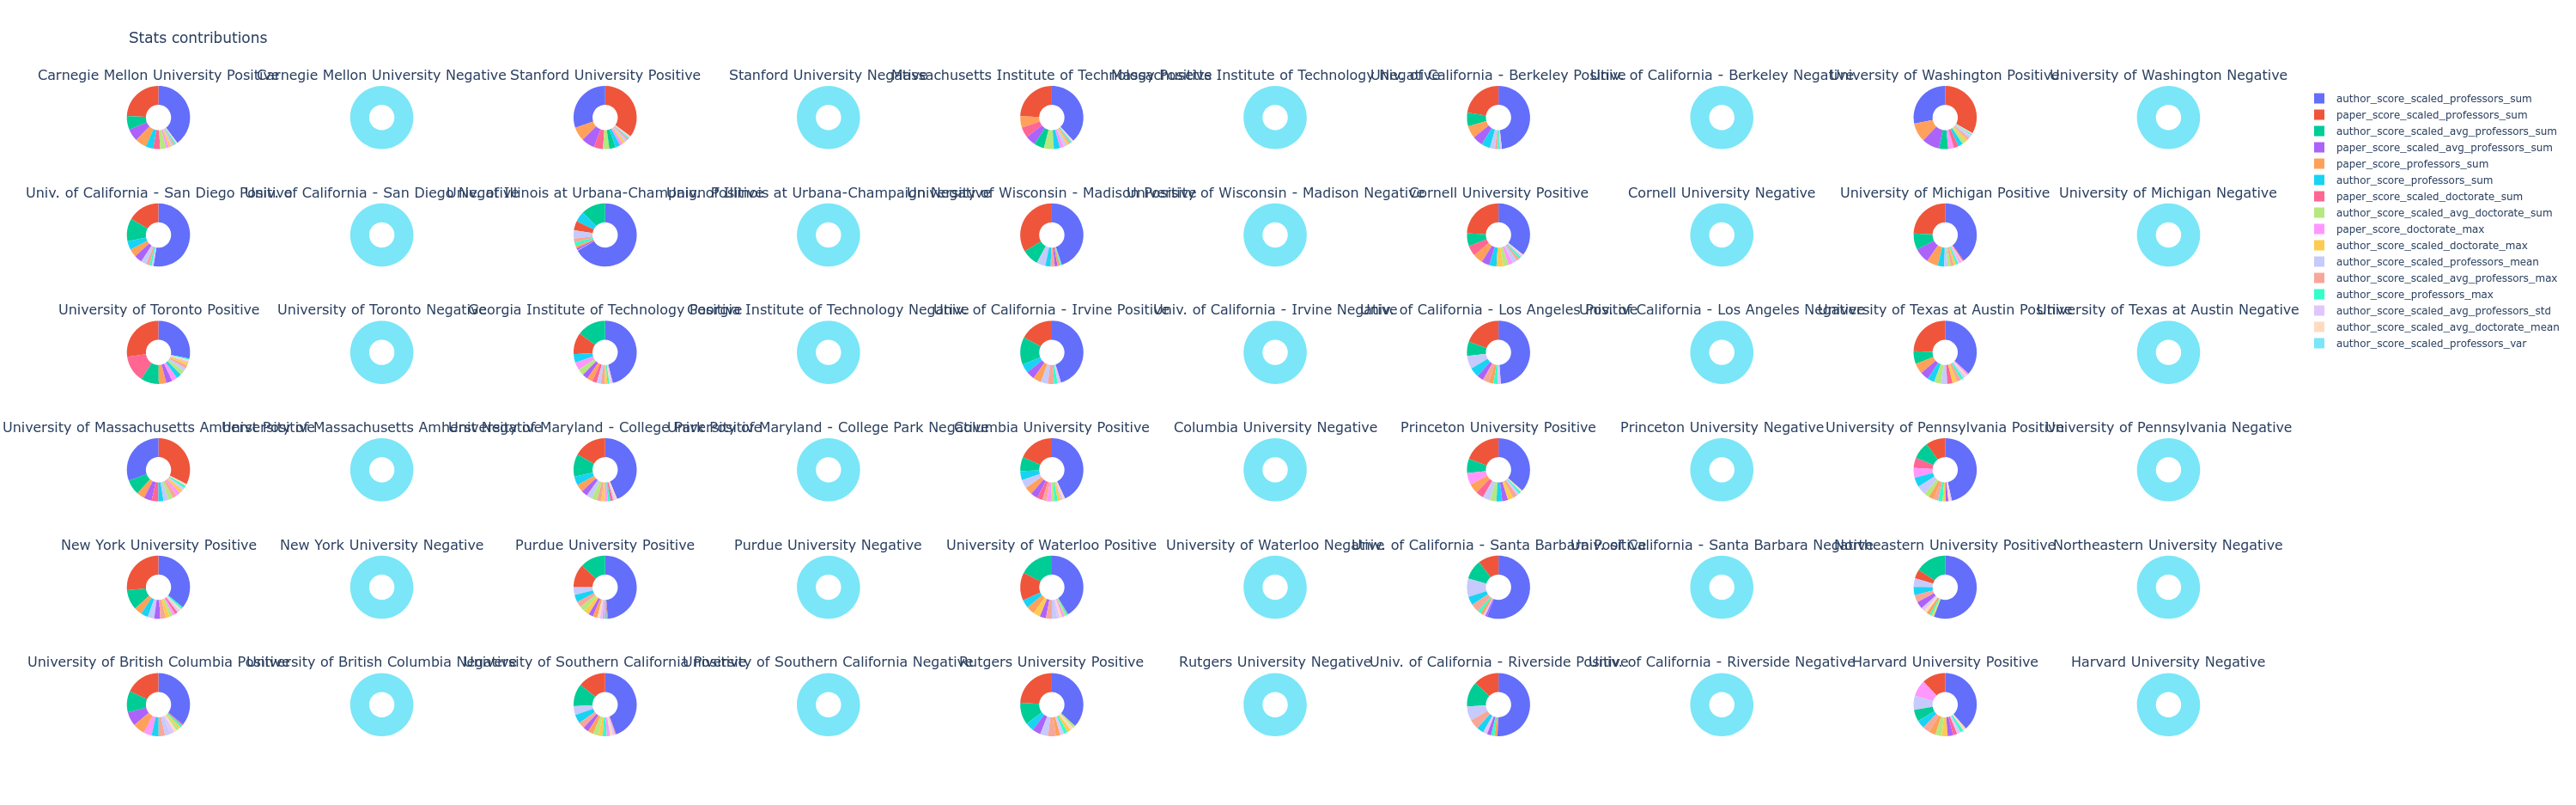

In [84]:
labels = dfstatistics["stat"].tolist()

data_array = final_results.head(number_of_results)[
    [
        "university",
        "final_array",
    ]
].reset_index()

custom_title = "Stats contributions"

num_rows = int(np.ceil(np.sqrt(number_of_results)))
num_cols = int(np.ceil(number_of_results / num_rows))

specs = [[{'type': 'pie'}, {'type': 'pie'}] * num_cols] * num_rows

titles = []
for d in data_array["university"].tolist():
    titles.append(f"{d} Positive")
    titles.append(f"{d} Negative")
    
fig = make_subplots(
    rows=num_rows,
    cols=num_cols*2,
    subplot_titles=titles,
    specs=specs,
)

for i in range(number_of_results):
    row = i // num_cols + 1
    col = (i % num_cols) * 2 + 1 
    pos_val, pos_label, neg_val, neg_label = get_signed_lists(
        data_array["final_array"].iloc[i], labels
    )
    pos_pie_trace = go.Pie(
        labels=pos_label,
        values=pos_val,
        textinfo="none",
        hoverinfo="label+percent",
        hole=0.4,
    )
    
    neg_pie_trace = go.Pie(
        labels=neg_label,
        values=neg_val,
        textinfo="none",
        hoverinfo="label+percent",
        hole=0.4,       
    )

    fig.add_trace(pos_pie_trace, row=row, col=col)
    fig.add_trace(neg_pie_trace, row=row, col=col+1)

fig.update_layout(title_text=custom_title, showlegend=True)

fig.show()

In [ ]:
def write_out_stats(university, file):
    dfuniversity[dfuniversity["university"] == university].iloc[0].to_csv(file)


# write_out_stats("Columbia University", "columbia.csv")

In [ ]:
dfscore.sort_values("combined_score", ascending=False).head(20)[
    ["name", "combined_score"]
]